**W**elcome to the CHAMPS competition.  In this competition, we're given a suite of several hundred thousand molecules whose structure has been previously computed by density functional theory.  This comes from a standard library of molecules used for large data / high throughput chemical calculations.  From the geometry, we're asked to predict the magnitude of magnetic coupling between proton and nitrogen atoms, proton-proton coupling, and carbon-proton couplings.  This data could be experimentally collected by Nuclear Magnetic Resonance (NMR) experiments, the data provided instead is a theoretically computed value for the coupling.  As a physical chemist myself, that's an important distinction becuase a lot of my practical intuition has certain concepts baked in that simply don't apply here.  For example, I automatically think that certain interactions will be wiped out by spatial movement and ensemble averaging, which won't be the case for this competition.  

As a chemist, I think the most interesting part of this machine learning exercise is not the problem as given, per se, but rather the inverse problem. Given an NMR spectrum, with measured couplings, can machine learning accurately predict molecular structure.  This would be a huge advance allowing a very common and relatively inexpensive technique to to predict structure without human intervention.  This is a common task learned by anyone who's ever taken an organic chemistry lab, and taking the human element out of it was be a game changer.  With that concept in mind, let's first look at the data, and see what we're working with

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#Let's load some libraries that we'll need to take a look at our data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import multiprocessing as mp
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

In [ ]:
##Setup some matplotlib details
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

In [ ]:
#Input the data
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
structures=pd.read_csv('../input/structures.csv')
train.head()


Let's take a quick look at the data we're given.  For each entry in the training and test files we're asked to predict, we'll see that we have a molecular file name, the two atoms involved in the coupling, and the type of coupling,  For every molecule in the structures.csv file, we have a list of the atoms and their X, Y, and Z coordinates

In [ ]:
train.head()

In [ ]:
structures.head()

One of the things that I'll point out is that the structural information as given **DOES NOT** directly show any "chemical" information.  It doesn't list which atoms are bonded to which, or what the distances and angles are between atoms.  All of that information will need to be inferred or computed by the people persuing this competition.  
Luckily, chemists have been studying molecules for a long time, and there are some handy tools for converting a molecule  in what we call an "xyz" format to something with more implied information.  Personally, in my modeling sets I've used openbabel and its child pybel a lot.  These are completely opensource python (and c++) modules that apply standard chemical knowledge to learn such structural information, and it can neatly solve some other questions, such as is there a ring in the molecule.  Some types of coupling, particularly the 1JHN and 1JHC are paritcularly sensitive to ring strain and what the chemist would call the s- and p- character of the bond involved.  To learn more about openbabel, visit https://openbabel.org 

Effectively, this competition boils down to 8 separate competitions and the total score is just the average of how well you do on each one.  Let's look at the largest and the smallest of the two competitions, the type 1JHN, looking at proton-nitrogen nearest neighbor couplings and the type 3JHC, Carbon Hydrogen coupling which is a much larger dataset due to the high number of carbon and protons in these molecules.

In [ ]:
#We're giong to start separating our data by type sets: 1JHN and 3JHC
train1JHN=train[train['type']=='1JHN']
test1JHN=test[test['type']=='1JHN']
train3JHC=train[train['type']=='3JHC']
test3JHC=test[test['type']=='3JHC']


In [ ]:
print('There are {} unique atoms'.format(structures['atom'].nunique()))
print('Those atoms are {}'.format(structures['atom'].unique()))

In [ ]:
def element_to_atomic_number(ele):
    """ Given an input string that is an element's symbol, output its atomic number"""
    ele_to_atomic_number={'C':6, 'H':1, 'N':7, 'O':8, 'F':9}
    return ele_to_atomic_number[ele]


In [ ]:
print('The largest value for X is {} and the smallest value is {}'.format(structures['x'].max(),structures['x'].min()))
print('The largest value for Y is {} and the smallest value is {}'.format(structures['y'].max(),structures['y'].min()))
print('The largest value for Z is {} and the smallest value is {}'.format(structures['z'].max(),structures['z'].min()))
#These numbers are important if we end up using conv or capsule nets for regression on the potential
xspread=structures['x'].max()-structures['x'].min()
yspread=structures['y'].max()-structures['y'].min()
zspread=structures['z'].max()-structures['z'].min()
print('The smallest box that would hold all molecules in the data set is: ({0:.2f}x{1:.2f}x{2:.2f}) Angstroms'.format(xspread,yspread,zspread))

In [ ]:
#We'll build a list of the molecule names in each type we want to explore
train1JHN.describe()
mol1JHN=train1JHN['molecule_name'].unique()
mol_test1JHN=test1JHN['molecule_name'].unique()
mol3JHC=train3JHC['molecule_name'].unique()
mol_test3JHC=test3JHC['molecule_name'].unique()
structures1JHN=structures[structures['molecule_name'].isin(mol1JHN)]
structures_test1JHN=structures[structures['molecule_name'].isin(mol_test1JHN)]
structures3JHC=structures[structures['molecule_name'].isin(mol3JHC)]
structures_test3JHC=structures[structures['molecule_name'].isin(mol_test3JHC)]

In [ ]:
def get_info(struct):
    """get_info(struct) takes in a pandas dataframe object from structures.csv of all structures with a given molecular name 
        and outputs the number of atoms, the total # of electrons, and the molecule's spread in X,Y,Z,"""
    n_atoms=len(struct)
    spread_x=struct['x'].max()-struct['x'].min()
    spread_y=struct['y'].max()-struct['y'].min()
    spread_z=struct['z'].max()-struct['z'].min()
    spread=np.array([spread_x,spread_y,spread_z])
    electrons=0
    for i in range(n_atoms):
        electrons +=element_to_atomic_number(struct.iloc[i]['atom'])
    return n_atoms, electrons,spread
        

In [ ]:
sample=5000
n_atoms1JHN=np.zeros((sample,1)).astype(int)
total_electrons1JHN=np.zeros((sample,1)).astype(int)
n_atoms3JHC=np.zeros((sample,1)).astype(int)
total_electrons3JHC=np.zeros((sample,1)).astype(int)
spread1JHN=np.zeros((sample,3))
spread3JHC=np.zeros((sample,3))
for i, name in enumerate(np.random.choice(mol1JHN,sample,replace=False)):
    struct=structures1JHN[structures1JHN['molecule_name']==name]
    n_atoms1JHN[i],total_electrons1JHN[i],spread1JHN[i,:]=get_info(struct)
    if ((i+1)%1000 ==0) and (i !=0):
        print('Currently on the {}th name out of {} train1JHN samples'.format(i, sample))
for i, name in enumerate(np.random.choice(mol3JHC,sample,replace=False)):        
    struct=structures3JHC[structures3JHC['molecule_name']==name]
    n_atoms3JHC[i],total_electrons3JHC[i],spread3JHC[i,:]=get_info(struct)
    if ((i+1)%1000 ==0) and (i !=0):
        print('Currently on the {}th name out of {} train3JHC samples'.format(i, sample))


In [ ]:
n_atoms_test1JHN=np.zeros((sample,1)).astype(int)
total_electrons_test1JHN=np.zeros((sample,1)).astype(int)
n_atoms_test3JHC=np.zeros((sample,1)).astype(int)
total_electrons_test3JHC=np.zeros((sample,1)).astype(int)
spread_test1JHN=np.zeros((sample,3))
spread_test3JHC=np.zeros((sample,3))

for i, name in enumerate(np.random.choice(mol_test1JHN,sample,replace=False)):
    struct=structures_test1JHN[structures_test1JHN['molecule_name']==name]
    n_atoms_test1JHN[i],total_electrons_test1JHN[i],spread_test1JHN[i,:]=get_info(struct)
    if ((i+1)%1000 ==0) and (i !=0):
        print('Currently on the {}th name out of {} test1JHN samples'.format(i, sample))

for i, name in enumerate(np.random.choice(mol_test3JHC,sample,replace=False)):        
    struct=structures_test3JHC[structures_test3JHC['molecule_name']==name]
    n_atoms_test3JHC[i],total_electrons_test3JHC[i],spread_test3JHC[i,:]=get_info(struct)
    if ((i+1)%1000 ==0) and (i !=0):
        print('Currently on the {}th name out of {} test3JHC samples'.format(i, sample))

In [ ]:
f=plt.figure()
f.set_figheight(5)
f.set_figwidth(12.5)
ax1=plt.subplot(1,2,1)
tmp=plt.hist(n_atoms1JHN,density=True,bins=(n_atoms1JHN.max()-n_atoms1JHN.min()),alpha=1,label='1JHN Training Data')
tmp=plt.hist(n_atoms_test1JHN,density=True, bins=(n_atoms_test1JHN.max()-n_atoms_test1JHN.min()),alpha=.5, color='green',label='1JHN Test Data')
plt.legend(loc='upper left')
plt.xlabel('Number of Atoms in Molecule')
plt.ylabel('Frequency')
plt.title('# of Atoms in 1JHN Molecules')

#Plot # of atoms for 3JHC
ax1=plt.subplot(1,2,2)
tmp=plt.hist(n_atoms3JHC,density=True,bins=(n_atoms3JHC.max()-n_atoms3JHC.min()),alpha=1,label='3JHC Training Data')
tmp=plt.hist(n_atoms_test3JHC,density=True, bins=(n_atoms_test3JHC.max()-n_atoms_test3JHC.min()),alpha=.5, color='green',label='3JHC Test Data')
plt.legend(loc='upper left')
plt.xlabel('Number of Atoms in Molecule')
plt.ylabel('Frequency')
plt.title('# of Atoms in 3JHC Molecules')
plt.show()

In [ ]:
g=plt.figure()
g.set_figheight(5)
g.set_figwidth(12.5)

#Plot Z or # of electrons for 1JHN
ax1=plt.subplot(1,2,1)
tmp=plt.hist(total_electrons1JHN,density=True,bins=(total_electrons1JHN.max()-total_electrons1JHN.min()),alpha=1,label='1JHN Training Data')
tmp=plt.hist(total_electrons_test1JHN,density=True, bins=(total_electrons_test1JHN.max()-total_electrons_test1JHN.min()),alpha=.5, color='green',label='1JHN Test Data')
plt.legend(loc='upper left')
plt.xlabel('Number of Electrons in Molecule')
plt.ylabel('Frequency')
plt.title('# of Electrons in 1JHN Molecules')

#Plot Z or # of electrons for 3JHC
ax2=plt.subplot(1,2,2)
tmp=plt.hist(total_electrons3JHC,density=True,bins=(total_electrons3JHC.max()-total_electrons3JHC.min()),alpha=1,label='3JHC Training Data')
tmp=plt.hist(total_electrons_test3JHC,density=True, bins=(total_electrons_test3JHC.max()-total_electrons_test3JHC.min()),alpha=.5, color='green',label='3JHC Test Data')
plt.legend(loc='upper left')
plt.xlabel('Number of Electrons in Molecule')
plt.ylabel('Frequency')
plt.title('# of Electrons in 3JHC molecules')
plt.show()


So by examining the distributions of the smallest (1JHN) and the largest (3JHC) datasets, we can see that these training data do a pretty reasonable approximation of data we'll be trying to predict.  They have the same mean to within about 1 part per thousand.  They  have the same number of atoms / molecule and the same atomic distributions.  Next we'll just double check that they have roughly the same size by comparing the average height,width, and depth and associated standard deviation of molecules in the train and test sets

In [ ]:
f=plt.figure()
f.set_figheight(5)
f.set_figwidth(20)
ax1=plt.subplot(1,3,1)
h=plt.hist(np.vstack((spread1JHN[:,0],spread_test1JHN[:,0])).T, density=True, bins=30,label=['X Spread Train1JHN','X Spread Test1JHN'])
plt.legend(loc='upper left')
plt.xlabel('Spread in X')
plt.ylabel('Frequency')
ax1.text(6,0.3,'<X> = {0:.2f} train \nand {1:.2f} test'.format(spread1JHN[:,0].mean(), spread_test1JHN[:,0].mean()))
ax1.text(6,0.23,'<$\sigma_X$> = {0:.2f} train\n and {1:.2f} test'.format(spread1JHN[:,0].std(), spread_test1JHN[:,0].std()))
ax2=plt.subplot(1,3,2)
h=plt.hist(np.vstack((spread1JHN[:,1],spread_test1JHN[:,1])).T, density=True, bins=30,label=['Y Spread Train1JHN','Y Spread Test1JHN'])
plt.legend(loc='upper left')
plt.xlabel('Spread in Y')
plt.ylabel('Frequency')
ax2.text(6,0.3,'<Y> = {0:.2f} train\n and {1:.2f} test'.format(spread1JHN[:,1].mean(), spread_test1JHN[:,1].mean()))
ax2.text(6,0.23,'<$\sigma_Y$> = {0:.2f} train\n and {1:.2f} test'.format(spread1JHN[:,1].std(), spread_test1JHN[:,1].std()))
ax3=plt.subplot(1,3,3)
h=plt.hist(np.vstack((spread1JHN[:,2],spread_test1JHN[:,2])).T, density=True,bins=30,label=['Z Spread Train1JHN','Z Spread Test1JHN'])
plt.legend(loc='upper left')
plt.xlabel('Spread in Z')
plt.ylabel('Frequency')
ax3.text(6,0.3,'<Z> = {0:.2f} train\n and {1:.2f} test'.format(spread1JHN[:,2].mean(), spread_test1JHN[:,2].mean()))
ax3.text(5.5,0.23,'<$\sigma_Z$> = {0:.2f} train\n and {1:.2f} test'.format(spread1JHN[:,2].std(), spread_test1JHN[:,2].std()))
plt.show()

In [ ]:
f=plt.figure()
f.set_figheight(5)
f.set_figwidth(20)
ax1=plt.subplot(1,3,1)
h=plt.hist(np.vstack((spread3JHC[:,0],spread_test3JHC[:,0])).T, density=True, bins=30,label=['X Spread Train3JHC','X Spread Test3JHC'])
plt.legend(loc='upper left')
plt.xlabel('Spread in X')
plt.ylabel('Frequency')
ax1.text(6,0.3,'<X> = {0:.2f} train \nand {1:.2f} test'.format(spread3JHC[:,0].mean(), spread_test3JHC[:,0].mean()))
ax1.text(6,0.23,'<$\sigma_X$> = {0:.2f} train\n and {1:.2f} test'.format(spread3JHC[:,0].std(), spread_test3JHC[:,0].std()))
ax2=plt.subplot(1,3,2)
h=plt.hist(np.vstack((spread3JHC[:,1],spread_test3JHC[:,1])).T, density=True, bins=30,label=['Y Spread Train3JHC','Y Spread Test3JHC'])
plt.legend(loc='upper left')
plt.xlabel('Spread in Y')
plt.ylabel('Frequency')
ax2.text(6,0.3,'<Y> = {0:.2f} train\n and {1:.2f} test'.format(spread3JHC[:,1].mean(), spread_test3JHC[:,1].mean()))
ax2.text(6,0.23,'<$\sigma_Y$> = {0:.2f} train\n and {1:.2f} test'.format(spread3JHC[:,1].std(), spread_test3JHC[:,1].std()))
ax3=plt.subplot(1,3,3)
h=plt.hist(np.vstack((spread3JHC[:,2],spread_test3JHC[:,2])).T, density=True,bins=30,label=['Z Spread Train3JHC','Z Spread Test3JHC'])
plt.legend(loc='upper left')
plt.xlabel('Spread in Z')
plt.ylabel('Frequency')
ax3.text(6,0.3,'<Z> = {0:.2f} train\n and {1:.2f} test'.format(spread3JHC[:,2].mean(), spread_test3JHC[:,2].mean()))
ax3.text(5.5,0.23,'<$\sigma_Z$> = {0:.2f} train\n and {1:.2f} test'.format(spread3JHC[:,2].std(), spread_test3JHC[:,2].std()))
plt.show()

So it looks like the training set is a fair proxy for the test set, spatially as well.  There are other tests that one could do to check for specific things that I expect are highly correlated with NMR shift such as number of ring density and stastical planarity, but at this point I'm satisfied that the training and test sets have roughly the same distributions

**T**he next step in processing this data would be to start modelling it, and looking for patterns in how the scalar coupling constant (J) varies based on the features in our training set.  The only problem, our features at this point are nigh useless.  The only info we have immediate access to is the location of each atom and the atom type.  So while one could make a few plots of J vs the number of atoms in the molecule, or the number of oxygens, or the spatial extent, we won't actually learn much other than show some ugly barely correlated blobs.  Given the high level of precision I expect to see winning the competition, our feature set as given is completely unaccessable.  
So there are two approaches as I see it:
1.   Feature Engineering.   There are a ton of geometric features one could use.  For example, one could use the distance between the two coupled atoms.  That definitely shows a correlation with J, but it is non linear.  Looking up some physics shows that one might expect dipole-dipole interactions to scale like 1/R_6, so we could have a separate feature for each molecule that calculates the inverse 6th power of the bond length.  Of course, that's just the classical interaction.  Quantum mechanically I might expect to see a perturbation series containing all of the even powers of 1/R.  So maybe we calculate the first 20 or so and add that to our features.  And then maybe it depends strongly on the angles (and dihedral angles for the 3JHN,3JHH,3JHC).  It does, but again its a non-linear non-trivial function.  So we could throw in a bunch of trig functions (sine, cosine, tan, cos^2, etc) as features. To illustrate this, I've plotted the coupling constant vs bond length and a specific bond angle for 5000 molecules from the 1JHN training set. As you can see, there is a correlation between these features, but a lot of scatter.  That scatter is **NOT** noise, but caused by correlation to other features that we're not plotting.   Which features are important and critical? Noone knows, that's why need ML to help us out.  Once we've come up with an exhaustive list of features, really throwing everything under the sun at it, we could use a nice gradient boosting model to help us find the best approximation.  While the gradient boosting will find non-linear solutions of our features, its ability to predict will be highly depdendent on what features we tell it are possible.
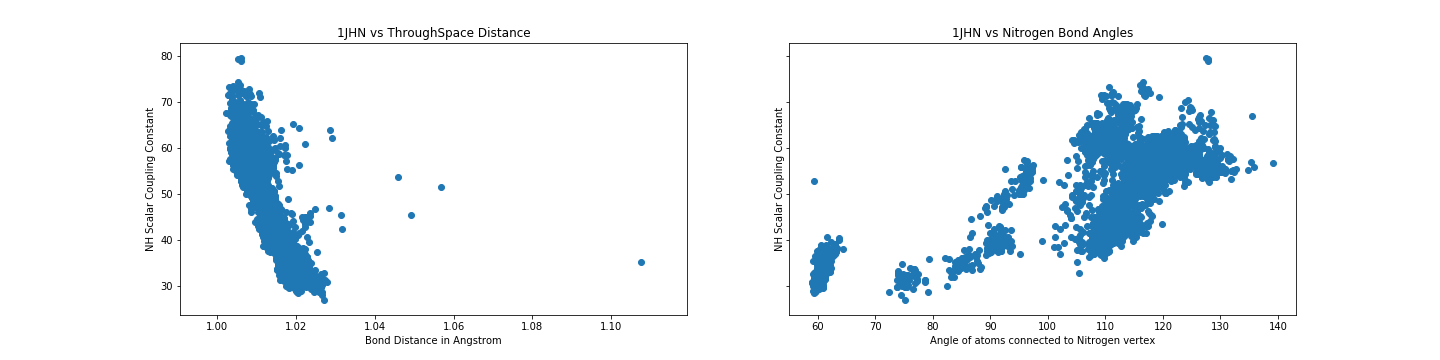
2.  Neural Networks.  The other way to approach this problem is to say not only do I not know what features are important, I don't think anyone does.  Instead, lets see if the computer can learn the rules on its own.  So I have some kernels which take the atomic level inputs, calculate a 3D image of the corresponding potentials, and then use neural networks and image processing to calculate the corresponding rules to map a given potential to a coupling constant J

At first glance, both of these seem like they could be highly prone to overfitting.  But here I want to make a critical distinction between this data and most datasets.  There **IS** mathematical function that takes the molecule's geometry and then outputs the coupling constant.  It may be a highly complicated, non-linear, non-local function, that is non analytic but these data were achieved via a computer doing a well specified set of tasks (I'm not sure of exactly how they were calculated, but almost certainly it involves building Coulomb's potential for this molecule, expressing the electron density as a sum of atom-centered gaussian functions, iterating the Kohn Sham equations with some functional that approximates the energy as function of the density by adjusting the density until selfconsistency is achieved, and then looking at derivatives of the resulting potential with respect to a magnetic field or orbital occupations).  That process is involved, but it is a one-to-one and onto mapping. Moreover, it is also not subject to random error.  If the procedure says that the coupling is J, then it is J plus or minus some small number to account for numerical accuracy (in this case 10^-9 as we're told).  So before worrying about traditional overfitting, realize that it is okay if the models gives lots of weight to some oddball configurations.  If another molecule is in an arbitrarily close location in chemical configuration space, it will have a similar coupling constant J.  Of course, this also means that if your training set has enough data, a K-nearest neighbors approach could also be highly accurate.  I think that may work well for the datasets where you have over a million training examples, but for smaller sets such as 1JHN I'd be suprised if we have enough data there.  

Alright, that's about it for my EDA on this project.  It's time to start making some models which will appear in different kernels.  I'm effectively new to approaching this type of project from a data science viewpoint, so I'd love to hear any comments or questions you might have on how I'm thinking about and approaching this compeition.

Cheers,
James